# Accelerated Calderón preconditioning of the PMCHWT equation

This notebook accompanies the paper 'Accelerated Calderón preconditioning for Maxwell transmission problems' by Kleanthous et al. The example code below replicates results from Section 5, Figure 10. To obtain Figures 11-12 change the frequency to 183GHz and 325GHz respectively. 

We first import all necessary packages. To be able to use the cutoff parameter, you need Bempp version 3.3.5 (Docker image) or 3.3.4 (source code) 

In [1]:
import bempp.api
print(bempp.api.__version__)
import numpy as np
import time
from login import gmres 
from operators import PMCHWT_operator, get_memory

bempp.api.set_ipython_notebook_viewer()

3.3.4


Next we set up the parameters for the operator and preconditioner when a bi-parametric implementation is used.


In [2]:
from bempp.core.common.global_parameters import global_parameters # Interface to define global_parameters for operators

quad_P= [1,1,1,1]
quad_A= [4,3,2,6]

hmat_tol_P = 0.1
hma_tol_A = 0.001

near_field_cutoff_P = 0

# Parameters for Operator A
parameters_A = global_parameters()
parameters_A.assembly.boundary_operator_assembly_type='hmat'
parameters_A.hmat.eps = hma_tol_A
parameters_A.quadrature.double_singular = quad_A[3]
parameters_A.quadrature.far.double_order = quad_A[2]
parameters_A.quadrature.medium.double_order = quad_A[1]
parameters_A.quadrature.near.double_order = quad_A[0]

# Parameters for Preconditioner P
parameters_P = global_parameters()
parameters_P.assembly.boundary_operator_assembly_type='hmat'
parameters_P.hmat.eps = hmat_tol_P
parameters_P.quadrature.double_singular = quad_P[3]
parameters_P.quadrature.far.double_order = quad_P[2]
parameters_P.quadrature.medium.double_order = quad_P[1]
parameters_P.quadrature.near.double_order = quad_P[0]
parameters_P.hmat.cutoff = near_field_cutoff_P

Set up the frequency, grid and properties of the scatterer

In [3]:
frequency = 50E9
wavelength = (3E8/frequency)*10**3 #scale to mm
print('wavelength: {0}'.format(wavelength))
k_ext = 2 *np.pi/wavelength
print('mesh size: {0}'.format(2*np.pi/(10*k_ext)))

if frequency == 50E9:
    r = 1.7754+0.00066j
elif frequency == 183E9:
    r = 1.7754+0.00243j
elif frequency == 325E9:
    r = 1.7754+0.0044j
elif frequency == 664E9:
    r=1.7754+0.00972j
    
number_of_scatterers = 8
ref_index = [r] * number_of_scatterers
k_int= [k_ext * i for i in ref_index]

print("The exterior wavenumber is: {0}".format(k_ext))
print("The interior wavenumbers are: {0}".format(k_int[0]))

mu_int = number_of_scatterers * [1.0]
mu_ext = 1.0

grids = []
for i in range(number_of_scatterers):
    new_grid = bempp.api.import_grid('8aggregate_' + str(int(frequency*1E-9)) +'GHz/1cm/hex' + str(i) + '.msh')
    grids.append(new_grid)
    
sum_elements = 0
for i in range(number_of_scatterers):
    el = grids[0].leaf_view.elements
    sum_elements += el.shape[1]
print('Total elements: {0}'.format(sum_elements))

wavelength: 6.0
mesh size: 0.6000000000000001
The exterior wavenumber is: 1.0471975511965976
The interior wavenumbers are: (1.8591945323944394+0.0006911503837897544j)
Total elements: 2016


If you want to test for the 3 cubes of Section 4, comment out the above and use the below

In [4]:
# wavelength = 0.55 
# print('wavelength: {0}'.format(wavelength))
# k_ext = 2 *np.pi/wavelength
# h=2*np.pi/(10*k_ext)
# print('mesh size: {0}'.format(h))

# centers = [(-1,0,0), (0,0,0), (1,0,0)]
# radius = .4
# number_of_scatterers = len(centers)

# r = 1.311 + 2.289E-9j

# ref_index = [r] * number_of_scatterers
# k_int= [k_ext * i for i in ref_index]

# print("The exterior wavenumber is: {0}".format(k_ext))
# print("The interior wavenumbers are: {0}".format(k_int[0]))

# mu_int = number_of_scatterers * [1.0]
# mu_ext = 1.0

# grids = [bempp.api.shapes.cube(length = radius, origin=c, h=h) for c in centers]
    
# sum_elements = 0
# for i in range(number_of_scatterers):
#     el = grids[0].leaf_view.elements
#     sum_elements += el.shape[1]
# print('Total elements: {0}'.format(sum_elements))

Set up the incoming plane wave

In [5]:
theta = np.pi / 4 # Incident wave travelling at a 45 degree angle
direction = np.array([np.cos(theta), 0, np.sin(theta)])
polarization = np.array([0, 1.0, 0])

def plane_wave(point):
    return polarization * np.exp(1j * k_ext * np.dot(point, direction))

def dirichlet_trace_fun(point, n, domain_index, result):
    result[:] =  np.cross(plane_wave(point), n)

def plane_wave_curl(point):
    return np.cross(direction, polarization) * 1j * k_ext * np.exp(1j * k_ext * np.dot(point, direction))

def neumann_trace_fun(point, n, domain_index, result):
    result[:] =  1./ (1j * k_ext) * np.cross(plane_wave_curl(point), n)

In [6]:
# spaces
bc_space = [bempp.api.function_space(grid, "BC", 0) for grid in grids]
rbc_space = [bempp.api.function_space(grid, "RBC", 0) for grid in grids]
rwg_space = [bempp.api.function_space(grid, "RWG", 0) for grid in grids]
snc_space = [bempp.api.function_space(grid, "SNC", 0) for grid in grids]

b_rwg_space = [bempp.api.function_space(grid, "B-RWG", 0) for grid in grids]
b_snc_space = [bempp.api.function_space(grid, "B-SNC", 0) for grid in grids]

N = sum([space.global_dof_count for space in rwg_space])
print (N ,'NDOF')

2556 NDOF


Set up the operators. The following sets up the PMCHWT operator $\mathcal{A}$ with parameters_A, and the preconditioners $\mathcal{D}$, $\mathcal{D}^i$, $\mathcal{S}^i$ with parameters_A first and with parameters_P (bi-parametric implementation) after. This is the example presented in Figure 10. You can also set up $\mathcal{D}^e$ and $\mathcal{S}^e$ by setting type_of_preconditioner = 'exterior' and 'exterior_electric' respectively. 

In [7]:
[PMCHWT_A, filter_operators] = PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, parameters = parameters_A)

PMCHWT_D = PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, preconditioner = True, parameters = parameters_A,
                                 type_of_preconditioner = 'diagonal')
PMCHWT_Di = PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, preconditioner=True, parameters = parameters_A,
                                      type_of_preconditioner='interior')
PMCHWT_Si = PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, preconditioner=True, parameters=parameters_A,
                                                   type_of_preconditioner = 'interior_electric')

PMCHWT_D_bp = PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, preconditioner = True, parameters = parameters_P,
                                    type_of_preconditioner = 'diagonal')
PMCHWT_Di_bp = PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, preconditioner = True, parameters = parameters_P,
                                         type_of_preconditioner='interior')
PMCHWT_Si_bp = PMCHWT_operator(grids, k_ext, k_int, mu_ext, mu_int, preconditioner = True, 
                                                  parameters = parameters_P, type_of_preconditioner='interior_electric')

Create inverse mass-matrices

In [8]:
print('creating mass-matrices')
# BC discretisation
mass_matrix_BC_SNC = np.empty((2 * number_of_scatterers, 2 * number_of_scatterers), dtype='O')
t0 = time.time()
for i in range(number_of_scatterers):
    for j in range(number_of_scatterers):
        if i==j:
            id_BC_SNC = bempp.api.operators.boundary.sparse.identity(bc_space[i], bc_space[i], b_snc_space[i])
            inv_identity_BC_SNC = bempp.api.assembly.InverseSparseDiscreteBoundaryOperator(id_BC_SNC.weak_form())
            mass_matrix_BC_SNC[2*i, 2*j] = inv_identity_BC_SNC
            mass_matrix_BC_SNC[2*i + 1, 2*j + 1] = inv_identity_BC_SNC
mass_matrix_BC_SNC = bempp.api.assembly.BlockedDiscreteOperator(mass_matrix_BC_SNC)
ta_mass_matrix_BC_SNC = time.time() - t0
print('assembly time for mass_matrix_BC_SNC: {0} seconds'.format(ta_mass_matrix_BC_SNC))

mass_matrix_BRWG_RBC = np.empty((2*number_of_scatterers, 2*number_of_scatterers), dtype = 'O')
t0 = time.time()
for i in range(number_of_scatterers):
    for j in range(number_of_scatterers):
        if i==j:
            id_BRWG_RBC = bempp.api.operators.boundary.sparse.identity(b_rwg_space[i], b_rwg_space[i], rbc_space[i])
            inv_identity_BRWG_RBC = bempp.api.assembly.InverseSparseDiscreteBoundaryOperator(id_BRWG_RBC.weak_form())
            mass_matrix_BRWG_RBC[2*i, 2*j] = inv_identity_BRWG_RBC
            mass_matrix_BRWG_RBC[2*i + 1, 2*j+1] = inv_identity_BRWG_RBC
mass_matrix_BRWG_RBC = bempp.api.assembly.BlockedDiscreteOperator(mass_matrix_BRWG_RBC)
ta_mass_matrix_BRWG_RBC = time.time() - t0
print('assembly time for mass_matrix_bc: {0} seconds'.format(ta_mass_matrix_BRWG_RBC))

creating mass-matrices
assembly time for mass_matrix_BC_SNC: 0.06866073608398438 seconds
assembly time for mass_matrix_bc: 0.05539822578430176 seconds


Assemble the operator and preconditioners

In [9]:
print('assembly of PMCHWT operator A')

t0 = time.time()
PMCHWT_A_wf = PMCHWT_A.weak_form()
PMCHWT_A_sf = mass_matrix_BC_SNC * PMCHWT_A_wf
ta_PMCHWT_A = time.time() - t0 + ta_mass_matrix_BC_SNC
mem_A = get_memory(number_of_scatterers, PMCHWT_A_wf)
print('assembly time of A: {0} mins'.format(ta_PMCHWT_A/60))
print('mem(A): {0} Gb \n'.format(mem_A * 1E-6))

print('assembly of preconditioner D and operator DA')
t0 = time.time()
PMCHWT_D_wf = PMCHWT_D.weak_form()
PMCHWT_D_sf = mass_matrix_BRWG_RBC * PMCHWT_D_wf
ta_D = time.time() - t0 + ta_mass_matrix_BRWG_RBC
op_DA_sf = PMCHWT_D_sf * PMCHWT_A_sf
ta_DA = ta_D + ta_PMCHWT_A 
mem_D = get_memory(number_of_scatterers, PMCHWT_D_wf)
print('assembly time of DA: {0} mins'.format(ta_DA/60))
print('mem(D): {0} Gb \n'.format(mem_D * 1E-6))

print('assembly of preconditioner Di and operator DiA')
t0 = time.time()
PMCHWT_Di_wf = PMCHWT_Di.weak_form()
PMCHWT_Di_sf = mass_matrix_BRWG_RBC * PMCHWT_Di_wf
ta_Di = time.time() - t0 + ta_mass_matrix_BRWG_RBC
op_DiA_sf =  PMCHWT_Di_sf * PMCHWT_A_sf
ta_DiA = ta_Di + ta_PMCHWT_A 
mem_Di = get_memory(number_of_scatterers, PMCHWT_Di_wf)
print('assembly time of DiA: {0} mins'.format(ta_DiA/60))
print('mem(Di): {0} Gb \n'.format(mem_Di * 1E-6))

print('assembly of preconditioner Si and operator SiA')
t0 = time.time()
PMCHWT_Si_wf = PMCHWT_Si.weak_form()
PMCHWT_Si_sf = mass_matrix_BRWG_RBC * PMCHWT_Si_wf
ta_Si = time.time() - t0 + ta_mass_matrix_BRWG_RBC
op_SiA_sf =  PMCHWT_Si_sf * PMCHWT_A_sf
ta_SiA = ta_Si + ta_PMCHWT_A 
mem_Si = get_memory(number_of_scatterers, PMCHWT_Si_wf)
print('assembly time of SiA: {0} mins'.format(ta_SiA/60))
print('mem(Si): {0} Gb \n'.format(mem_Si * 1E-6))

print('assembly of preconditioner D_bp and operator DA_bp')
t0 = time.time()
PMCHWT_D_bp_wf = PMCHWT_D_bp.weak_form()
PMCHWT_D_bp_sf = mass_matrix_BRWG_RBC * PMCHWT_D_bp_wf
ta_D_bp = time.time() - t0 + ta_mass_matrix_BRWG_RBC
op_DA_bp_sf = PMCHWT_D_bp_sf * PMCHWT_A_sf
ta_DA_bp = ta_D_bp + ta_PMCHWT_A 
mem_D_bp = get_memory(number_of_scatterers, PMCHWT_D_bp_wf)
print('assembly time of DA_bp: {0} mins'.format(ta_DA_bp/60))
print('mem(D_bp): {0} Gb \n'.format(mem_D_bp * 1E-6))

print('assembly of preconditioner Di_bp and operator DiA_bp')
t0 = time.time()
PMCHWT_Di_bp_wf = PMCHWT_Di_bp.weak_form()
PMCHWT_Di_bp_sf = mass_matrix_BRWG_RBC * PMCHWT_Di_bp_wf
ta_Di_bp = time.time() - t0 + ta_mass_matrix_BRWG_RBC
op_DiA_bp_sf =  PMCHWT_Di_bp_sf * PMCHWT_A_sf
ta_DiA_bp = ta_Di_bp + ta_PMCHWT_A 
mem_Di_bp = get_memory(number_of_scatterers, PMCHWT_Di_bp_wf)
print('assembly time of DiA_bp: {0} mins'.format(ta_DiA_bp/60))
print('mem(Di_bp): {0} Gb \n'.format(mem_Di_bp * 1E-6))

print('assembly of preconditioner Si_bp and operator SiA_bp')
t0 = time.time()
PMCHWT_Si_bp_wf = PMCHWT_Si_bp.weak_form()
PMCHWT_Si_bp_sf = mass_matrix_BRWG_RBC * PMCHWT_Si_bp_wf
ta_Si_bp = time.time() - t0 + ta_mass_matrix_BRWG_RBC
op_SiA_bp_sf =  PMCHWT_Si_bp_sf * PMCHWT_A_sf
ta_SiA_bp = ta_Si_bp + ta_PMCHWT_A 
mem_Si_bp = get_memory(number_of_scatterers, PMCHWT_Si_bp_wf)
print('assembly time of SiA_bp: {0} mins'.format(ta_SiA_bp/60))
print('mem(Si_bp): {0} Gb \n'.format(mem_Si_bp * 1E-6))

assembly of PMCHWT operator A
assembly time of A: 0.14966416756312054 mins
mem(A): 0.139899 Gb 

assembly of preconditioner D and operator DA
assembly time of DA: 0.643035622437795 mins
mem(D): 1.2422268125 Gb 

assembly of preconditioner Di and operator DiA
assembly time of DiA: 0.40134403308232625 mins
mem(Di): 0.62554640625 Gb 

assembly of preconditioner Si and operator SiA
assembly time of SiA: 0.28264798323313395 mins
mem(Si): 0.32130820312499997 Gb 

assembly of preconditioner D_bp and operator DA_bp
assembly time of DA_bp: 0.24735668500264485 mins
mem(D_bp): 0.3047648125 Gb 

assembly of preconditioner Di_bp and operator DiA_bp
assembly time of DiA_bp: 0.19672290086746216 mins
mem(Di_bp): 0.15238240625 Gb 

assembly of preconditioner Si_bp and operator SiA_bp
assembly time of SiA_bp: 0.17528144121170045 mins
mem(Si_bp): 0.076191203125 Gb 



Assembling the RHS

In [10]:
# Assembly of RHS operators
# Discretize the incident field
incident_field = number_of_scatterers * [None]
for i in range(number_of_scatterers):
    dirichlet_trace = bempp.api.GridFunction(rwg_space[i], fun=dirichlet_trace_fun)
    neumann_trace = (k_ext/mu_ext) * bempp.api.GridFunction(rwg_space[i], fun = neumann_trace_fun)
    incident_field[i] = dirichlet_trace.coefficients.tolist() +  neumann_trace.coefficients.tolist()

rhs_wf = []
for i in range(number_of_scatterers):
    rhs_wf.append(filter_operators[i].weak_form() * incident_field[i])
rhs_wf = [y for x in rhs_wf for y in x]

rhs_DA = op_DA_sf * mass_matrix_BC_SNC * rhs_wf
rhs_DiA = op_DiA_sf * mass_matrix_BC_SNC * rhs_wf
rhs_SiA = op_SiA_sf * mass_matrix_BC_SNC * rhs_wf
rhs_DA_bp = op_DA_bp_sf * mass_matrix_BC_SNC * rhs_wf
rhs_DiA_bp = op_DiA_bp_sf * mass_matrix_BC_SNC * rhs_wf
rhs_SiA_bp = op_SiA_bp_sf * mass_matrix_BC_SNC * rhs_wf

Sovling the linear systems

In [11]:
tolerance = 1e-5
restart = 200
maxiter = 400

print('solving DA')
t0 = time.time()
sol_DA, info_DA, res_DA = gmres(op_DA_sf, rhs_DA, tol = tolerance, restart = restart, return_residuals=True, maxiter=maxiter)
ts_DA = time.time() - t0
print('number of iterations: {0}'.format(len(res_DA)))
print('GMRES times: {0} mins \n'.format(ts_DA/60))

print('solving DiA')
t0 = time.time()
sol_DiA, info_DiA, res_DiA = gmres(op_DiA_sf, rhs_DiA, tol = tolerance, restart = restart, return_residuals=True, 
                                   maxiter=maxiter)
ts_DiA = time.time() - t0
print('number of iterations: {0}'.format(len(res_DiA)))
print('GMRES times: {0} mins \n'.format(ts_DiA/60))

print('solving SiA')
t0 = time.time()
sol_SiA, info_SiA, res_SiA = gmres(op_SiA_sf, rhs_SiA, tol = tolerance, restart = restart, return_residuals=True, 
                                   maxiter=maxiter)
ts_SiA = time.time() - t0
print('number of iterations: {0}'.format(len(res_SiA)))
print('GMRES times: {0} mins \n'.format(ts_SiA/60))

print('solving DA_bp')
t0 = time.time()
sol_DA_bp, info_DA_bp, res_DA_bp = gmres(op_DA_bp_sf, rhs_DA_bp, tol = tolerance, restart = restart, return_residuals=True, 
                                         maxiter=maxiter)
ts_DA_bp = time.time() - t0
print('number of iterations: {0}'.format(len(res_DA_bp)))
print('GMRES times: {0} mins \n'.format(ts_DA_bp/60))

print('solving DiA_bp')
t0 = time.time()
sol_DiA_bp, info_DiA_bp, res_DiA_bp = gmres(op_DiA_bp_sf, rhs_DiA_bp, tol = tolerance, restart = restart, return_residuals=True,
                                            maxiter=maxiter)
ts_DiA_bp = time.time() - t0
print('number of iterations: {0}'.format(len(res_DiA_bp)))
print('GMRES times: {0} mins \n'.format(ts_DiA_bp/60))

print('solving SiA_bp')
t0 = time.time()
sol_SiA_bp, info_SiA_bp, res_SiA_bp = gmres(op_SiA_bp_sf, rhs_SiA_bp, tol = tolerance, restart = restart, return_residuals=True,
                                            maxiter=maxiter)
ts_SiA_bp = time.time() - t0
print('number of iterations: {0}'.format(len(res_SiA_bp)))
print('GMRES times: {0} mins \n'.format(ts_SiA_bp/60))

solving DA
number of iterations: 16
GMRES times: 0.09820748170216878 mins 

solving DiA
number of iterations: 28
GMRES times: 0.10906987587610881 mins 

solving SiA
number of iterations: 89
GMRES times: 0.25891900062561035 mins 

solving DA_bp
number of iterations: 89
GMRES times: 0.48388458887736 mins 

solving DiA_bp
number of iterations: 46
GMRES times: 0.1641128698984782 mins 

solving SiA_bp
number of iterations: 61
GMRES times: 0.16633477210998535 mins 



# Comparing results

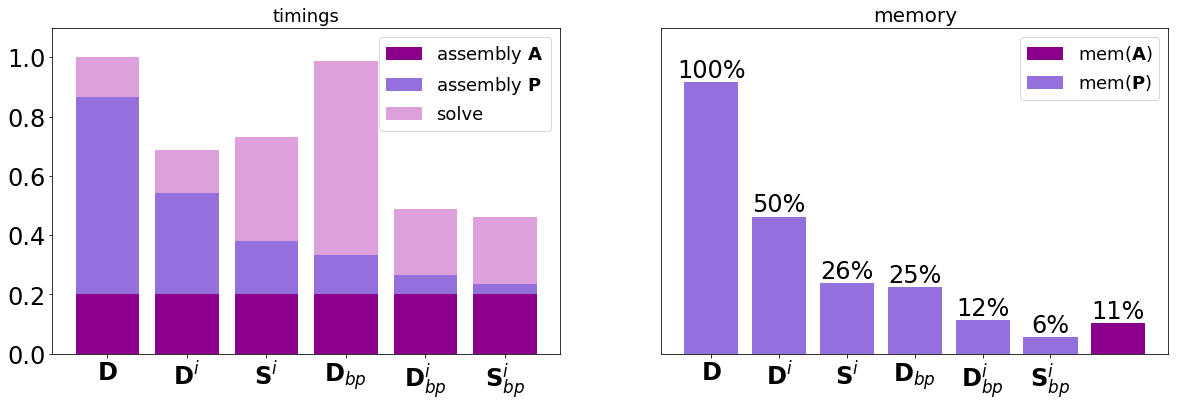

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 24})

xtickslist = list([r'$\mathbf{D}$', r'$\mathbf{D}^i$', r'$\mathbf{S}^i$', 
              r'$\mathbf{D}_{bp}$', r'$\mathbf{D}^i_{bp}$', r'$\mathbf{S}^i_{bp}$'])

x = [0,1,2,3,4,5]
xx = [6]
ta_A = [ta_PMCHWT_A/(ts_DA + ta_DA)]*6
ta_P =  [ta_D/(ts_DA + ta_DA), ta_Di/(ts_DA + ta_DA), 
       ta_Si/(ts_DA + ta_DA), ta_D_bp/(ts_DA + ta_DA), 
       ta_Di_bp/(ts_DA + ta_DA), ta_Si_bp/(ts_DA + ta_DA)]
ts = [ts_DA/(ts_DA + ta_DA), ts_DiA/(ts_DA + ta_DA), 
      ts_SiA/(ts_DA + ta_DA), ts_DA_bp/(ts_DA + ta_DA), 
      ts_DiA_bp/(ts_DA + ta_DA), ts_SiA_bp/(ts_DA + ta_DA)]
mem =  [mem_D/mem_D, mem_Di/mem_D, mem_Si/mem_D, mem_D_bp/mem_D, mem_Di_bp/mem_D, mem_Si_bp/mem_D]

fig, axs = plt.subplots(1,2,figsize = (20,6))
plt.setp(axs, xticks=x, xticklabels=xtickslist)

ta_A_bar = axs[0].bar(x, ta_A, label = r'assembly $\mathbf{A}$', color = 'darkmagenta')
ta_P_bar = axs[0].bar(x, ta_P, bottom = ta_A, label = r'assembly $\mathbf{P}$', color = 'mediumpurple')
ts_bar = axs[0].bar(x, ts, bottom = np.array(ta_A) + np.array(ta_P), label = 'solve', color = 'plum')
axs[0].legend(fontsize = 18)
axs[0].set_title('timings', fontsize = 18)
axs[0].set_ylim([0,1.1])

mem_bar2 = axs[1].bar(xx, [mem_A/mem_D], color = 'darkmagenta', label = r'mem($\mathbf{A}$)')
mem_bar = axs[1].bar(x, mem, color = 'mediumpurple', label = r'mem($\mathbf{P}$)')
axs[1].legend(fontsize = 18)
axs[1].set_title('memory', fontsize = 20)
axs[1].set_ylim([0,1.2])
axs[1].set_yticks([])

for rect in mem_bar:
    height = rect.get_height()
    axs[1].text(rect.get_x() + rect.get_width()/2.0, height, "{:.0%}".format(height), ha='center', va='bottom')
    
for rect in mem_bar2:
    height = rect.get_height()
    axs[1].text(rect.get_x() + rect.get_width()/2.0, height, "{:.0%}".format(height), ha='center', va='bottom')
